# Chapter 14 – Deep Computer Vision Using Convolutional Neural Networks

This notebook contains all the sample code and solutions to the exercises in chapter 14.

1. Next, let’s set up a Conda environment:

```
conda create --name tf_dev python=3.9
conda activate tf_dev
```

Make sure environment is activated for the rest of the installation

2. Install CUDA v11.2 and cuDNN v8.7 

3. Install TensorFlow 2.10.x so that it still supports local GPU
```
pip install "tensorflow<2.11" 
```

4. Fix the zlib.dll install issue by following advice in this thread:

https://stackoverflow.com/questions/72356588/could-not-locate-zlibwapi-dll-please-make-sure-it-is-in-your-library-path

* Find zlib.dll in ```C:\Program Files\NVIDIA Corporation\Nsight Systems 2022.x\host-windows-x64\zlib.dll```

* Renamed and copied it to: ```C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.2\bin\zlibwapi.dll```


## Setup
This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

And TensorFlow ≥ 2.8:

In [3]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

Current TensorFlow version:

In [4]:
version.parse(tf.__version__)

<Version('2.10.1')>

As we did in earlier chapters, let's define the default font sizes to make the figures prettier:

In [5]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

This chapter can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [6]:
# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

In [7]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Convolutional Layers
## Implementing Convolutional Layers With Keras
Let's load two sample images, rescale their pixel values to 0-1, and center crop them to small 70×120 images:

In [8]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

images = load_sample_images()["images"]

In [9]:
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)

In [10]:
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

In [11]:
images.shape

TensorShape([2, 70, 120, 3])

In [12]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

In [13]:
fmaps.shape

TensorShape([2, 64, 114, 32])

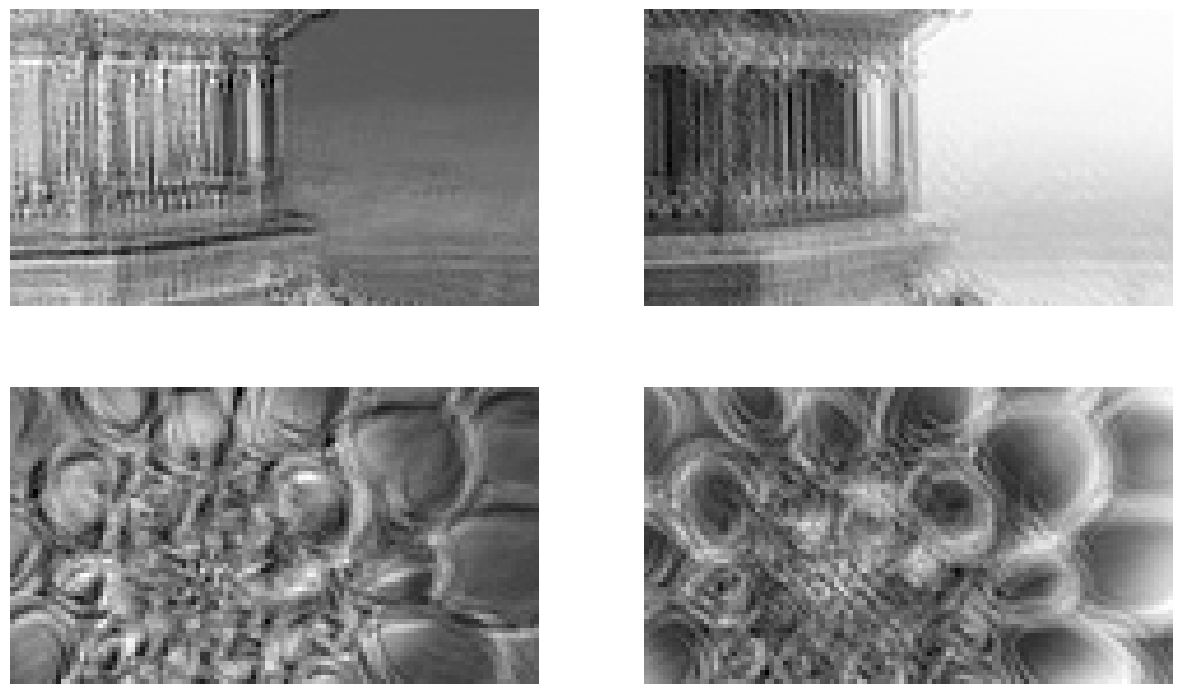

In [14]:
# extra code – displays the two output feature maps for each image

plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

As you can see, randomly generated filters typically act like edge detectors, which is great since that's a useful tool in image processing, and that's the type of filters that a convolutional layer typically starts with. Then, during training, it gradually learns improved filters to recognize useful patterns for the task.

Now let's use zero-padding:

In [15]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7,
                                    padding="same")
fmaps = conv_layer(images)

In [16]:
fmaps.shape

TensorShape([2, 70, 120, 32])

In [17]:
# extra code – shows that the output shape when we set strides=2
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same",
                                    strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [18]:
# extra code – this utility function can be useful to compute the size of the
#              feature maps output by a convolutional layer. It also returns
#              the number of ignored rows or columns if padding="valid", or the
#              number of zero-padded rows or columns if padding="same"."""

import numpy as np

def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding="same")

(array([35, 60]), array([5, 5]))

Let's now look at the weights:

In [19]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

In [20]:
biases.shape

(32,)

In [21]:
# extra code – shows how to use the tf.nn.conv2d() operation

tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 3, 2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

Let's manually create two filters full of zeros, except for a vertical line of 1s in the first filter, and a horizontal one in the second filter (just like in Figure 14–5). The two output feature maps highlight vertical lines and horizontal lines, respectively. In practice you will probably never need to create filters manually, since the convolutional layers will learn them automatically.

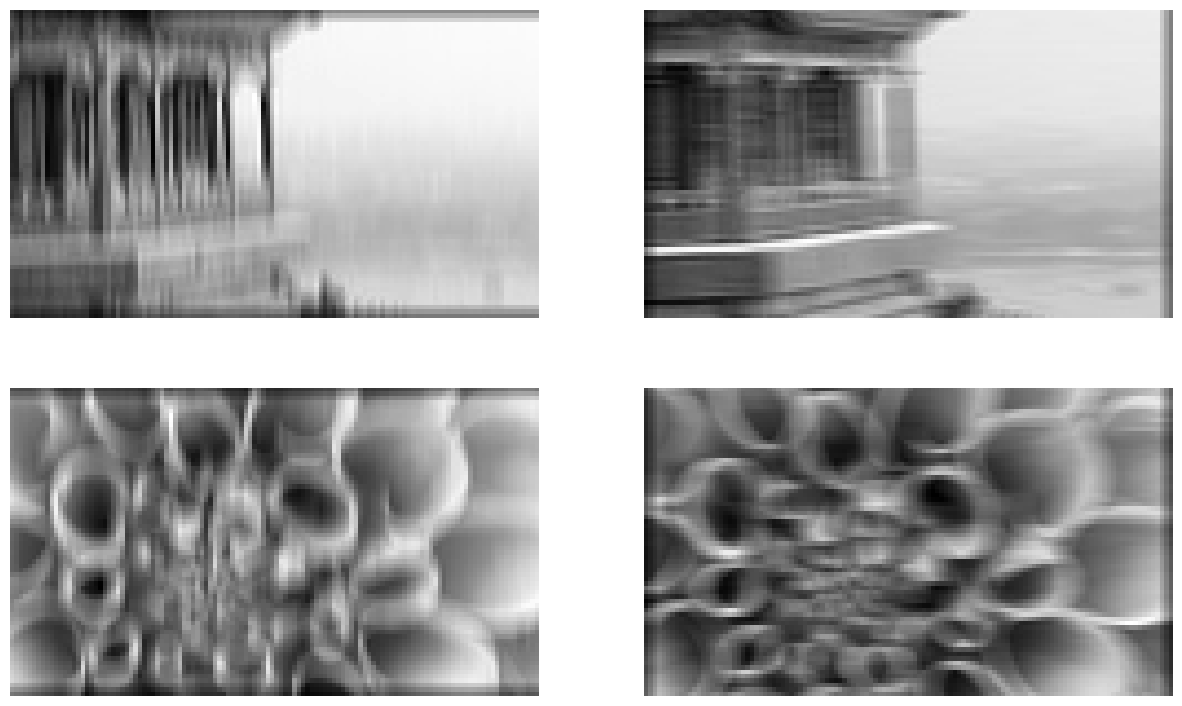

In [22]:
# extra code – shows how to manually create two filters to get images similar
#              to those in Figure 14–5.

plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

Notice the dark lines at the top and bottom of the two images on the left, and on the left and right of the two images on the right? Can you guess what these are? Why were they not present in the previous figure?

You guessed it! These are artifacts due to the fact that we used zero padding in this case, while we did not use zero padding to create the feature maps in the previous figure. Because of zero padding, the two feature maps based on the vertical line filter (i.e., the two left images) could not fully activate near the top and bottom of the images. Similarly, the two feature maps based on the horizontal line filter (i.e., the two right images) could not fully activate near the left and right of the images.

## Pooling Layers
### Implementing Pooling Layers With Keras
Max pooling

In [23]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [24]:
output = max_pool(images)

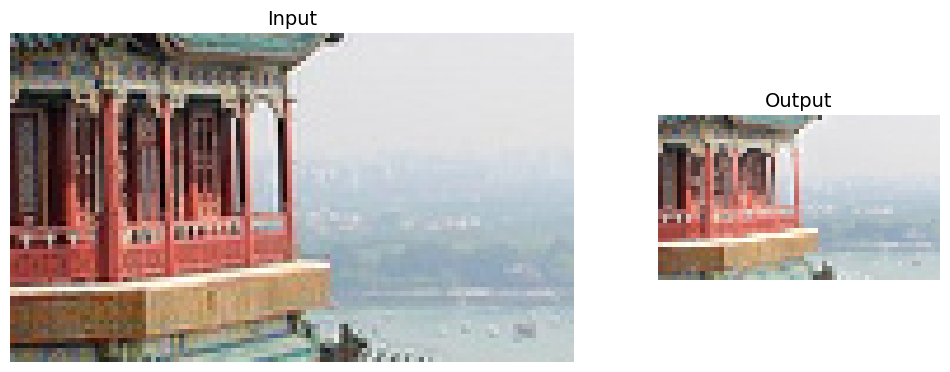

In [25]:
# extra code – this cells shows what max pooling with stride = 2 looks like

import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

**Depth-wise pooling**

In [26]:
# extra code – shows how to use the max_pool() op; only works on the CPU
np.random.seed(42)
fmaps = np.random.rand(2, 70, 120, 60)
with tf.device("/cpu:0"):
    output = tf.nn.max_pool(fmaps, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3),
                            padding="VALID")
output.shape

TensorShape([2, 70, 120, 20])

In [27]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
    
    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        groups = shape[-1] // self.pool_size  # number of channel groups
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

In [28]:

# extra code – shows that this custom layer gives the same result as max_pool()
np.allclose(DepthPool(pool_size=3)(fmaps), output)

True

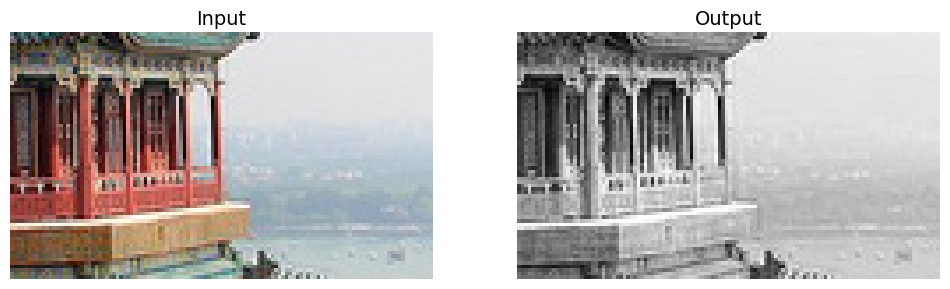

In [29]:
# extra code – computes and displays the output of the depthwise pooling layer

depth_output = DepthPool(pool_size=3)(images)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(images[0])  # plot the 1st image
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Output")
plt.imshow(depth_output[0, ..., 0], cmap="gray")  # plot 1st image's output
plt.axis("off")
plt.show()

**Global Average Pooling**

In [30]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

The following layer is equivalent:

In [31]:
global_avg_pool = tf.keras.layers.Lambda(
    lambda X: tf.reduce_mean(X, axis=[1, 2]))

In [32]:
global_avg_pool(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.643388  , 0.59718215, 0.5825038 ],
       [0.7630747 , 0.26010972, 0.10848834]], dtype=float32)>

## CNN Architectures
### Tackling Fashion MNIST With a CNN


In [33]:
# extra code – loads the mnist dataset, add the channels axis to the inputs,
#              scales the values to the 0-1 range, and splits the dataset
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [34]:
from functools import partial

tf.random.set_seed(42)  # extra code – ensures reproducibility
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")
model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

## LeNet-5
The famous LeNet-5 architecture had the following layers:

Layer	Type	Maps	Size	Kernel size	Stride	Activation

Out	Fully connected	–	10	–	–	RBF

F6	Fully connected	–	84	–	–	tanh

C5	Convolution	120	1 × 1	5 × 5	1	tanh

S4	Avg pooling	16	5 × 5	2 × 2	2	tanh

C3	Convolution	16	10 × 10	5 × 5	1	tanh

S2	Avg pooling	6	14 × 14	2 × 2	2	tanh

C1	Convolution	6	28 × 28	5 × 5	1	tanh

In	Input	1	32 × 32	–	–	–
